In [1]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import random
from particles import state_space_models as ssm
import particles

import os
from torchvision import datasets, transforms
from torch import nn 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [2]:
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 20.67it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

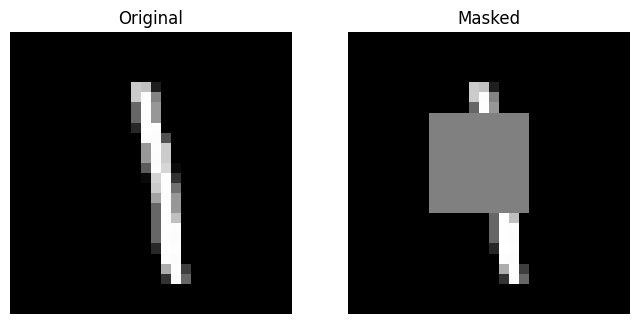

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load MNIST ---
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[31]
x0 = x0.numpy().squeeze()

# --- Mask ---
#test
x0 = x0 * 2.0 - 1.0   # [0,1] -> [-1,1]

mask = np.ones_like(x0)
mask[8:18,8:18] = 0
masked_img = x0 * mask #+ (mask - 1)
#masked_img = masked_img * 2.0 - 1.0 

# --- Flatten for SMC ---
x0_flat = x0.flatten()
mask_flat = mask.flatten().astype(bool)
obs_idx = np.where(mask_flat)[0]
miss_idx = np.where(~mask_flat)[0]
y_obs = x0_flat[obs_idx]
dx = x0_flat.size
dy = len(obs_idx)

# test
def to_img(x):
    return (x + 1.0) / 2

# --- Display original and masked ---
fig, ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].imshow(x0, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
# ax[1].imshow(masked_img, cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
ax[0].imshow(to_img(x0), cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(to_img(masked_img), cmap="gray"); ax[1].set_title("Masked"); ax[1].axis("off")
plt.show()

In [5]:
def to_img(x):
    return (x + 1.0) / 2.0

ax[0].imshow(to_img(x0), cmap="gray")
ax[1].imshow(to_img(masked_img), cmap="gray")

In [6]:
import torch
import numpy as np
from diffusers import DDPMPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet              # modèle eps_theta
scheduler = pipe.scheduler    # scheduler DDPM

# Scheduler arrays (torch tensors)
betas = scheduler.betas.to(device)                 # (T,)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)          # \bar alpha_t
sigmas = torch.sqrt(betas)                         # proxy sigma_t (comme dans ta codebase)

# Si tu veux rester en numpy pour ta codebase :
alpha_bars_np = alpha_bars.detach().cpu().numpy()
alpha_np = alphas.detach().cpu().numpy()
sigmas_np = sigmas.detach().cpu().numpy()


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 74.10it/s]


In [7]:
import torch.nn as nn

class DiffusersEpsWrapper(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, x, t):
        out = self.unet(x, t)
        return out.sample if hasattr(out, "sample") else out

eps_model = DiffusersEpsWrapper(unet).to(device).eval()


Step 195: 20 valid, 0 degenerate particles
Step 190: 20 valid, 0 degenerate particles
Step 185: 20 valid, 0 degenerate particles
Step 180: 20 valid, 0 degenerate particles
Step 175: 20 valid, 0 degenerate particles
Step 170: 20 valid, 0 degenerate particles
Step 165: 20 valid, 0 degenerate particles
Step 160: 20 valid, 0 degenerate particles
Step 155: 20 valid, 0 degenerate particles
Step 150: 20 valid, 0 degenerate particles
Step 145: 20 valid, 0 degenerate particles
Step 140: 20 valid, 0 degenerate particles
Step 135: 20 valid, 0 degenerate particles
Step 130: 20 valid, 0 degenerate particles
Step 125: 20 valid, 0 degenerate particles
Step 120: 20 valid, 0 degenerate particles
Step 115: 20 valid, 0 degenerate particles
Step 110: 20 valid, 0 degenerate particles
Step 105: 20 valid, 0 degenerate particles
Step 100: 20 valid, 0 degenerate particles
Step 95: 20 valid, 0 degenerate particles
Step 90: 20 valid, 0 degenerate particles
Step 85: 20 valid, 0 degenerate particles
Step 80: 20 va

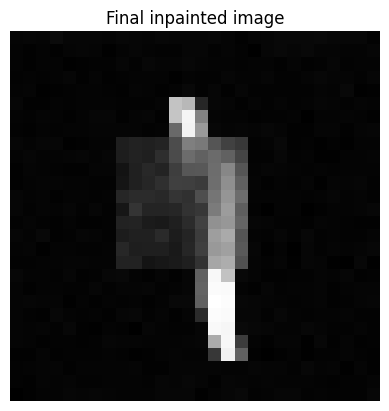

In [9]:
# --- Backward FK ---
class NoiselessBackwardFK:
    def __init__(self, y, obs_idx, miss_idx, alpha_bars, sigmas, model, dx):
        self.y = y
        self.obs_idx = obs_idx
        self.miss_idx = miss_idx
        self.dy = len(obs_idx)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.model = model
        self.dx = dx
        self.nsteps = len(alpha_bars) - 1

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_img = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_img, dtype=torch.float32, device=device)

        t_model = scheduler.timesteps[t]   # pas t directement
        t_tensor = torch.full((N,), t_model, device=device, dtype=torch.long)

        #t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        eps = self.model(x_tensor, t_tensor).cpu().numpy().reshape(N, -1)
        alpha_bar_t = np.maximum(self.alpha_bars[t], 1e-5)
        #print(eps[0, 0])
        
        chi = x / np.sqrt(alpha_bar_t) - np.sqrt(1 - alpha_bar_t) * eps
        #print("t", t, "alpha_bar", self.alpha_bars[t])
        #print("x_minmax", x.min(), x.max())
        #print("eps_minmax", eps.min(), eps.max())


        return chi

        #return chi

    def m(self, x_next, t):
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        Kt = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, self.obs_idx] = Kt * np.sqrt(alpha_bar) * self.y + (1 - Kt) * chi[:, self.obs_idx]
        return mean

    def M0(self, N):
        particles = np.zeros((N, self.dx))
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        Kn = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = Kn * np.sqrt(alpha_n) * self.y
        cov_obs = (((1 - alpha_n) * Kn)**2) * np.eye(self.dy)
        # manque carré (fix but a verif)
        particles[:, self.obs_idx] = np.random.multivariate_normal(mean_obs, cov_obs, size=N)
        particles[:, self.miss_idx] = np.random.randn(N, len(self.miss_idx))
        return particles

    def M(self, s, xp):
        mean = self.m(xp, s)
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        Ks = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        cov_obs = (1 - alpha_s) * Ks * np.eye(self.dy)
        new_obs = np.array([np.random.multivariate_normal(mean=m[self.obs_idx], cov=cov_obs) for m in mean])
        xp_new = xp.copy()
        xp_new[:, self.obs_idx] = new_obs

        # test
        xp_new[:, self.miss_idx] = (
                mean[:, self.miss_idx]
                + sigma_sp1 * np.random.randn(len(xp_new), len(self.miss_idx))
            )
        
        return xp_new


# --- PseudoSMC with snapshot saving ---
class PseudoSMC:
    def __init__(self, fk, N=5, snapshot_dir="./manual_smc_res"):
        self.fk = fk
        self.N = N
        self.snapshot_dir = snapshot_dir
        os.makedirs(snapshot_dir, exist_ok=True)

    def compute_weights(self, particles, s):
        mean = self.fk.m(particles, s)
        cov = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]
        log_w = np.zeros(self.N)
        for i in range(self.N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean[i, self.fk.obs_idx]
            # mauvais poids
            log_w[i] = -0.5 * diff @ diff / cov - 0.5 * self.fk.dy * np.log(2 * np.pi * cov)
        log_w -= np.max(log_w)
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            return np.ones(self.N) / self.N
        return w / np.sum(w)

    def resample(self, particles, weights):
        idx = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[idx]

    def run(self, snapshot_every=5):
        particles = self.fk.M0(self.N)
        start = 200
        #for s in reversed(range(self.fk.nsteps)):
        for s in reversed(range(start)):
            w = self.compute_weights(particles, s)
            particles = self.resample(particles, w)
            #print(particles[0, 0])
            particles = self.fk.M(s, particles)
            if s % snapshot_every == 0:
                is_valid = np.all(np.isfinite(particles), axis=1)
                n_valid = np.sum(is_valid)
                n_degen = self.N - n_valid

                if n_valid > 0:
                    recon = particles[is_valid].mean(axis=0).reshape(28, 28)
                else:
                    recon = np.zeros((28,28))

                filename = os.path.join(self.snapshot_dir, f"step_{s:04d}.png")
                plt.imsave(filename, recon, cmap="gray")
                print(f"Step {s}: {n_valid} valid, {n_degen} degenerate particles")
                plt.imsave(os.path.join(self.snapshot_dir, f"step_{s:04d}.png"), recon, cmap="gray")
        return particles

# --- Run full SMC ---
fk = NoiselessBackwardFK(y=y_obs, obs_idx=obs_idx, miss_idx=miss_idx,
                          alpha_bars=alpha_bars_np, sigmas=sigmas_np,
                          model=eps_model, dx=dx)

smc = PseudoSMC(fk, N=20)
particles_final = smc.run(snapshot_every=5)

# --- Show final reconstruction ---
recon = particles_final.mean(axis=0).reshape(28,28)
recon = particles_final[0].reshape(28,28)
recon = to_img(recon)
plt.imshow(recon, cmap="gray")
plt.title("Final inpainted image")
plt.axis("off")
plt.show()